In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import os
import imageio
from skimage.transform import resize, rescale
import datetime
import os

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import tensorflow as tf
print(tf.__version__)
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
tf.random.set_seed(30)


2.12.0


In [4]:
train_doc = np.random.permutation(open('/kaggle/input/gesture-recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/kaggle/input/gesture-recognition/Project_data/val.csv').readlines())
num_classes = 5  #number of softmax classes


In [5]:
curr_dt_time = datetime.datetime.now()
train_path = '/kaggle/input/gesture-recognition/Project_data/train'
val_path = '/kaggle/input/gesture-recognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


# training sequences = 663
# validation sequences = 100


## **Common Utils**

Common utility to plot loss and accuracy

In [6]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [7]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps


In [8]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]    


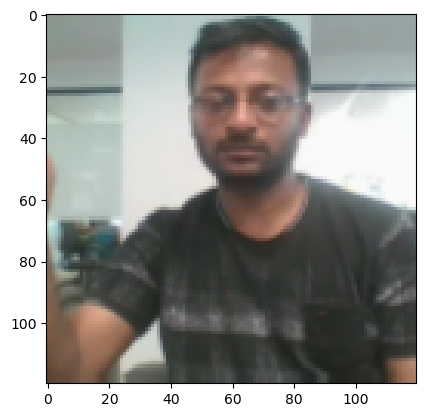

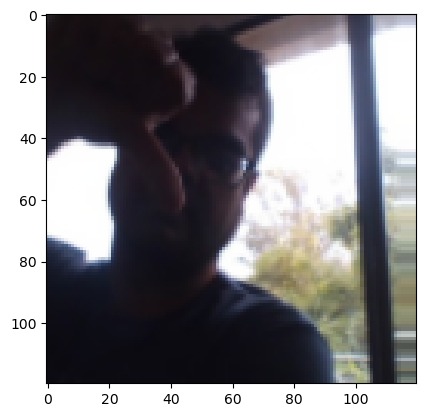

In [9]:
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import smart_resize

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

## Test code start
#360 by 360
image1 = imageio.imread("/kaggle/input/gesture-recognition/Project_data/train/WIN_20180907_15_38_17_Pro_Left Swipe_new_Left Swipe_new/WIN_20180907_15_38_17_Pro_00037.png")
#160 by 120
image2 = imageio.imread("/kaggle/input/gesture-recognition/Project_data/train/WIN_20180907_15_55_27_Pro_Thumbs Down_new/WIN_20180907_15_55_27_Pro_00014.png")
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes                    
#print(image1.shape, image2.shape)
image1 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)                   
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)                 
plt.imshow(image2)
plt.show()
## Test code end

def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        #img_idx = sorted(rn.sample(range(0, total_frames), num_images)) #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output           

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes                    
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image                  
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    #batch_data[folder,idx,:,:,0] = (image[...,0] - image[...,0].min())/(image[...,0].max() - image[...,0].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,1] = (image[...,1] - image[...,1].min())/(image[...,1].max() - image[...,1].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,2] = (image[...,2] - image[...,2].min())/(image[...,2].max() - image[...,2].min())#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers


In [11]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model


In [12]:
#num_epochs = 15 # choose the number of epochs
#print ('# epochs =', num_epochs)
#batch_size = 10 #experiment with the batch size
#print ('# batch size =', batch_size)
#num_frames = 30
#print ('# num_frames per video =', num_frames)
#height = 120
#width = 120

#model = conv3D(num_images=num_frames)

#print (model.summary())


# epochs = 15
# batch size = 10
# num_frames per video = 30
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                              

In [16]:
#callbacks_list = model_callbacks("model_conv3D_1")

#steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

#train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

#val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)


In [17]:
#history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             #callbacks=callbacks_list, validation_data=val_generator, 
                             #validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 0.4727 - categorical_accuracy: 0.7964
Epoch 1: val_loss improved from inf to 0.76397, saving model to model_conv3D_1_2023-08-2810_49_08.280454/model-00001-0.47270-0.79638-0.76397-0.71000.h5
67/67 [==============================] - 223s 3s/step - loss: 0.4727 - categorical_accuracy: 0.7964 - val_loss: 0.7640 - val_categorical_accuracy: 0.7100 - lr: 1.0000e-04
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 0.4264 - categorical_accuracy: 0.8431
Epoch 2: val_loss improved from 0.76397 to 0.64854, saving model to model_conv3D_1_2023-08-2810_49_08.280454/model-00002-0.42638-0.84314-0.64854-0.73000.h5
67/67 [==============================] - 214s 3s/step - loss: 0.4264 - categorical_accuracy: 0.8431 - val_loss: 0.6485 - val_categorical_accuracy: 0.7300 - lr: 1.0000e-04
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 0.4173 - categorical_accuracy: 0.8416
Epoch 3: val_loss did not improv

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


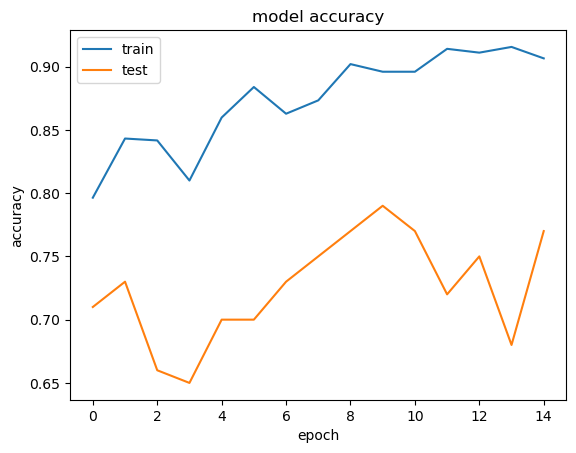

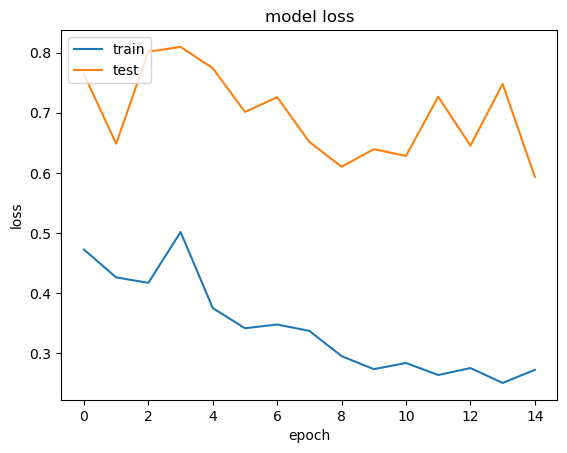

In [18]:
plot_loss_accuracy(history)

#### **Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)**

In [19]:
#num_epochs = 20 # choose the number of epochs
#print ('# epochs =', num_epochs)
#batch_size = 10  #experiment with the batch size
#print ('# batch size =', batch_size)
#num_frames = 20
#print ('# num_frames per video =', num_frames)
#height = 120
#width = 120

#model = conv3D(num_images=num_frames)

#print (model.summary())


# batch size = 10
# num_frames per video = 20
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_7 (Activation)   (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 32)    13856     
                                                                 
 activat

In [20]:
#callbacks_list = model_callbacks("model_conv3D_2")

#steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

#train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

# val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)


In [21]:
#history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              #callbacks=callbacks_list, validation_data=val_generator, 
                              #validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.6762 - categorical_accuracy: 0.3665
Epoch 1: val_loss improved from inf to 3.10974, saving model to model_conv3D_2_2023-08-2810_49_08.280454/model-00001-1.67622-0.36652-3.10974-0.17000.h5
67/67 [==============================] - 140s 2s/step - loss: 1.6762 - categorical_accuracy: 0.3665 - val_loss: 3.1097 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.2683 - categorical_accuracy: 0.5204
Epoch 2: val_loss did not improve from 3.10974
67/67 [==============================] - 136s 2s/step - loss: 1.2683 - categorical_accuracy: 0.5204 - val_loss: 4.4197 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.9706 - categorical_accuracy: 0.6380
Epoch 3: val_loss did not improve from 3.10974
67/67 [==============================] - 139s 2s/step - loss: 0.9706 - categorical_accuracy: 0.6380 - 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


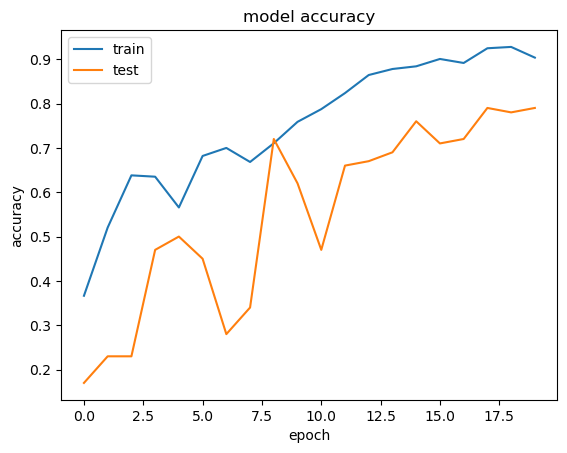

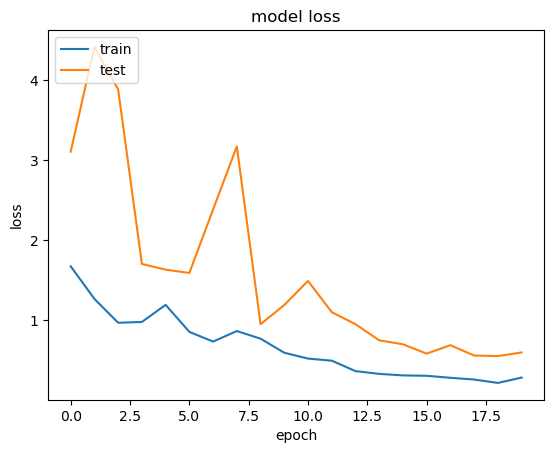

In [22]:
#plot_loss_accuracy(history)


#### **Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 160 by 160)**

In [23]:
#num_epochs = 20 # choose the number of epochs
#print ('# epochs =', num_epochs)
#batch_size = 10  #experiment with the batch size
#print ('# batch size =', batch_size)
#num_frames = 30
#print ('# num_frames per video =', num_frames)
#height = 160
#width = 160

#model = conv3D(num_images=num_frames, height=160, width=160)

#print (model.summary())


# epochs = 20
# batch size = 10
# num_frames per video = 30
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_14 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 80, 80, 32)    13856     
                                                            

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.



In [24]:
#callbacks_list = model_callbacks("model_conv3D_3")

#steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

#train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, height=160, width=160)

#val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames, height=160, width=160)


In [25]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.6595 - categorical_accuracy: 0.4178
Epoch 1: val_loss improved from inf to 5.78593, saving model to model_conv3D_3_2023-08-2810_49_08.280454/model-00001-1.65949-0.41780-5.78593-0.21000.h5
67/67 [==============================] - 279s 4s/step - loss: 1.6595 - categorical_accuracy: 0.4178 - val_loss: 5.7859 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.2009 - categorical_accuracy: 0.5732
Epoch 2: val_loss did not improve from 5.78593
67/67 [==============================] - 264s 4s/step - loss: 1.2009 - categorical_accuracy: 0.5732 - val_loss: 6.2769 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.8761 - categorical_accuracy: 0.6953
Epoch 3: val_loss did not improve from 5.78593
67/67 [==============================] - 267s 4s/step - loss: 0.8761 - categorical_accuracy: 0.6953 - 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


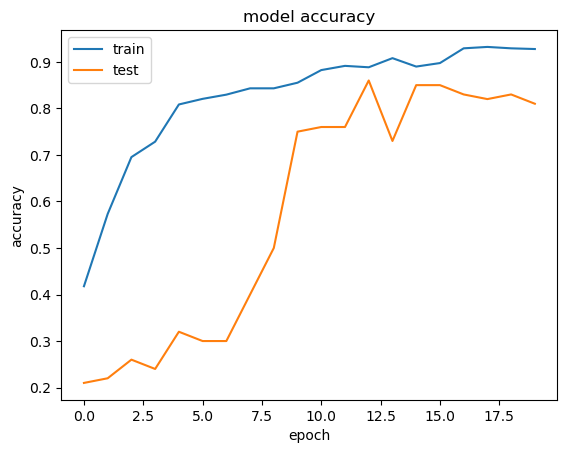

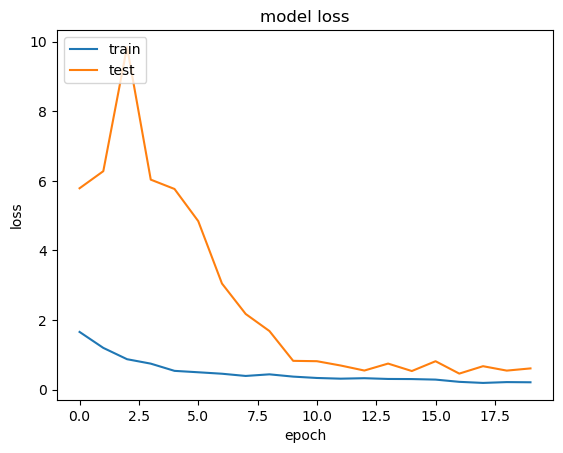

In [26]:
plot_loss_accuracy(history)

### **Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer) + Random data transformations on training data set**

In [30]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())


# epochs = 15
# batch size = 10
# num_frames per video = 30
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_28 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                            

In [31]:
callbacks_list = model_callbacks("model_conv3D_5")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)


In [35]:
#history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              #callbacks=callbacks_list, validation_data=val_generator, 
                              #validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


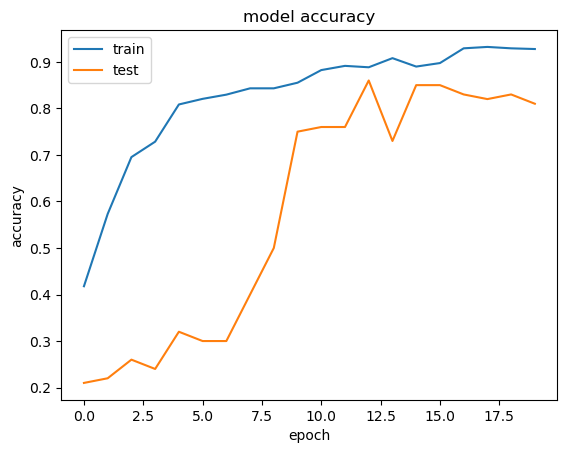

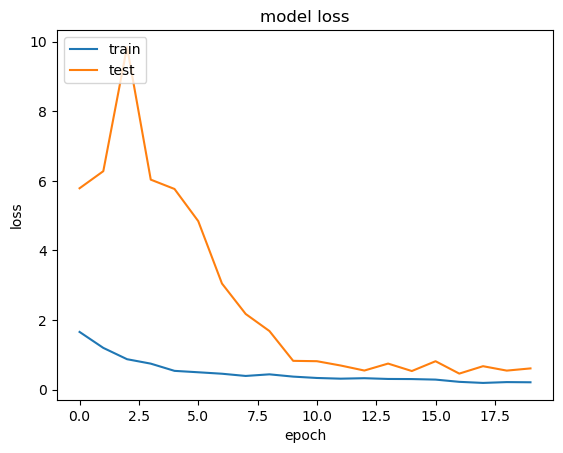

In [33]:
plot_loss_accuracy(history)


Conv 3D Model with 30 frames per video (8, 16, 32, 64 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)


In [36]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (8, 16, 32, 64) 
model = conv3D(conv_filters, num_images=num_frames)
print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 activation_35 (Activation)  (None, 30, 120, 120, 8)   0         
                                                                 
 batch_normalization_30 (Bat  (None, 30, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 15, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 15, 60, 60, 16)    3472      
                                                            

In [37]:
callbacks_list = model_callbacks("model_conv3D_6")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)


In [38]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.5348 - categorical_accuracy: 0.4495
Epoch 1: val_loss improved from inf to 3.70580, saving model to model_conv3D_6_2023-08-2810_49_08.280454/model-00001-1.53477-0.44947-3.70580-0.16000.h5
67/67 [==============================] - 223s 3s/step - loss: 1.5348 - categorical_accuracy: 0.4495 - val_loss: 3.7058 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.0459 - categorical_accuracy: 0.6078
Epoch 2: val_loss did not improve from 3.70580
67/67 [==============================] - 229s 3s/step - loss: 1.0459 - categorical_accuracy: 0.6078 - val_loss: 6.8378 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.8632 - categorical_accuracy: 0.6742
Epoch 3: val_loss did not improve from 3.70580
67/67 [==============================] - 209s 3s/step - loss: 0.8632 - categorical_accuracy: 0.6742 - 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


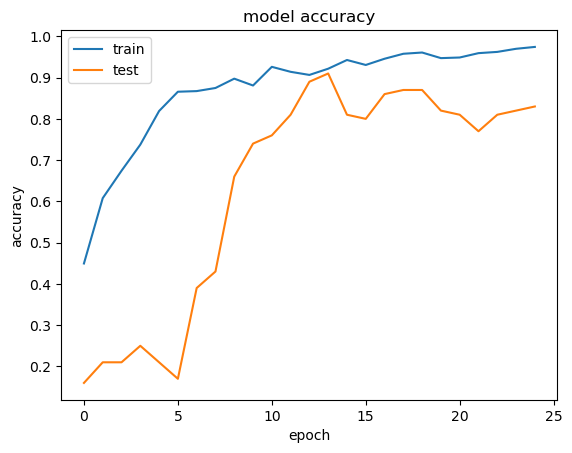

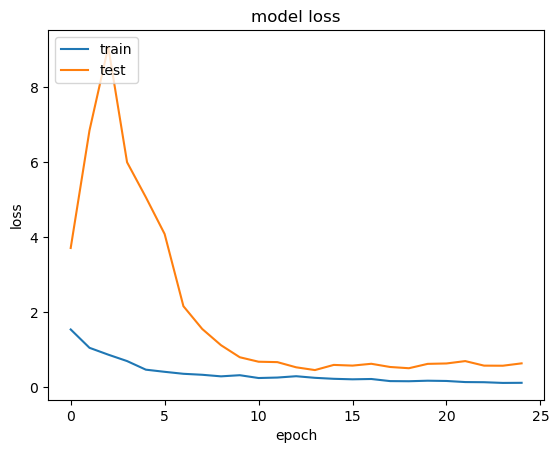

In [39]:
plot_loss_accuracy(history)

### **Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 128 dense layer + 64 dense layer + image size 120 by 120)**

In [40]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (16, 32, 64, 128)
dense_filters = (128, 64) 
model = conv3D(conv_filters=conv_filters, dense_nodes=dense_filters, dropout=0.2, num_images=num_frames)
print (model.summary())


# epochs = 25
# batch size = 10
# num_frames per video = 30
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_42 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_36 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                            

In [41]:
callbacks_list = model_callbacks("model_conv3D_7")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=False, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)


In [42]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.5853 - categorical_accuracy: 0.4087
Epoch 1: val_loss improved from inf to 2.80860, saving model to model_conv3D_7_2023-08-2810_49_08.280454/model-00001-1.58526-0.40875-2.80860-0.20000.h5
67/67 [==============================] - 223s 3s/step - loss: 1.5853 - categorical_accuracy: 0.4087 - val_loss: 2.8086 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.2029 - categorical_accuracy: 0.5068
Epoch 2: val_loss did not improve from 2.80860
67/67 [==============================] - 211s 3s/step - loss: 1.2029 - categorical_accuracy: 0.5068 - val_loss: 3.7778 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.9836 - categorical_accuracy: 0.6109
Epoch 3: val_loss did not improve from 2.80860
67/67 [==============================] - 208s 3s/step - loss: 0.9836 - categorical_accuracy: 0.6109 - 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


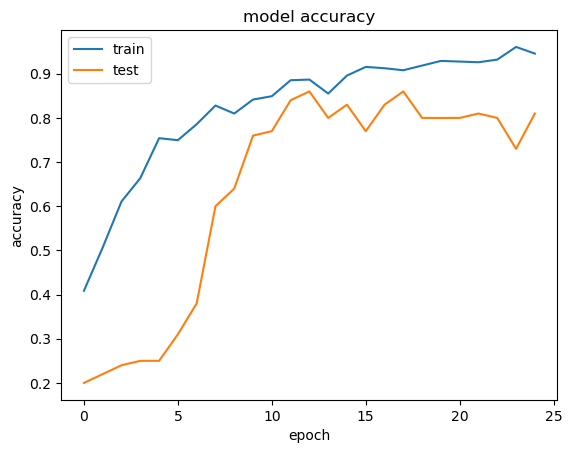

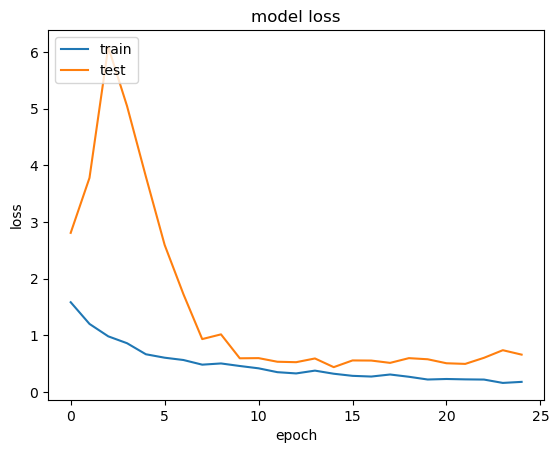

In [44]:
plot_loss_accuracy(history)

## **TRANSFER LEARNING - MobileNet Conv2d + GRU**

In [45]:
from keras.applications import mobilenet

def mobilenet_RNN(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    return model


Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes


In [46]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames, gru=True)
print (model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
17225924/17225924 [==============================] - 1s 0us/step
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 1024)         0         
 trib

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.



In [47]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)


In [48]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.0521 - categorical_accuracy: 0.5686
Epoch 1: val_loss improved from inf to 0.70990, saving model to model_retrain_mobilenet_gru_2023-08-2810_49_08.280454/model-00001-1.05212-0.56863-0.70990-0.73000.h5
67/67 [==============================] - 148s 2s/step - loss: 1.0521 - categorical_accuracy: 0.5686 - val_loss: 0.7099 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.5495 - categorical_accuracy: 0.7828
Epoch 2: val_loss improved from 0.70990 to 0.51246, saving model to model_retrain_mobilenet_gru_2023-08-2810_49_08.280454/model-00002-0.54954-0.78281-0.51246-0.83000.h5
67/67 [==============================] - 139s 2s/step - loss: 0.5495 - categorical_accuracy: 0.7828 - val_loss: 0.5125 - val_categorical_accuracy: 0.8300 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.3620 - categorical_accuracy: 0.8808
Epoch 3: val_l

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


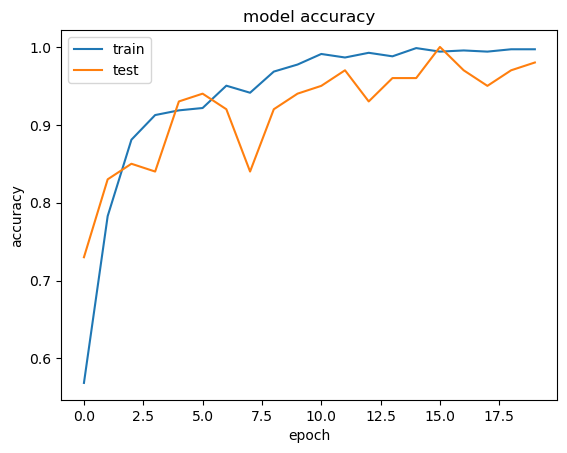

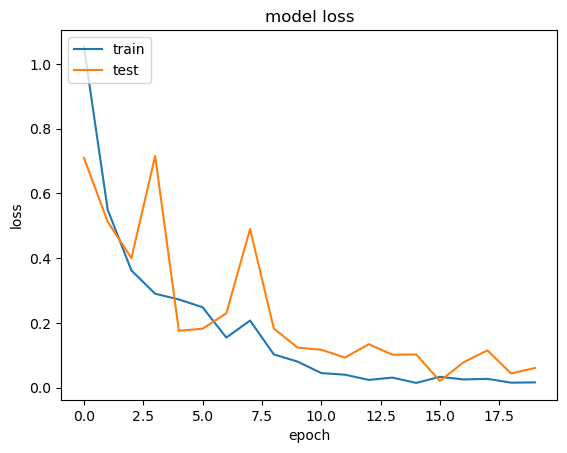

In [49]:
plot_loss_accuracy(history)


Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes + Random data transformations on training data set

In [50]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(gru=True, num_images=num_frames)
print(model.summary())


# epochs = 20
# batch size = 10
# num frames per video = 30
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 30, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 30, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 30, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 30, 1024)         0         
 tributed)                                                       
    

In [51]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)


In [52]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.1357 - categorical_accuracy: 0.5354
Epoch 1: val_loss improved from inf to 0.65452, saving model to model_retrain_mobilenet_gru_2023-08-2810_49_08.280454/model-00001-1.13573-0.53544-0.65452-0.77000.h5
67/67 [==============================] - 251s 4s/step - loss: 1.1357 - categorical_accuracy: 0.5354 - val_loss: 0.6545 - val_categorical_accuracy: 0.7700 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.4933 - categorical_accuracy: 0.8084
Epoch 2: val_loss improved from 0.65452 to 0.48878, saving model to model_retrain_mobilenet_gru_2023-08-2810_49_08.280454/model-00002-0.49327-0.80845-0.48878-0.77000.h5
67/67 [==============================] - 235s 4s/step - loss: 0.4933 - categorical_accuracy: 0.8084 - val_loss: 0.4888 - val_categorical_accuracy: 0.7700 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.3846 - categorical_accuracy: 0.8552
Epoch 3: val_l

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


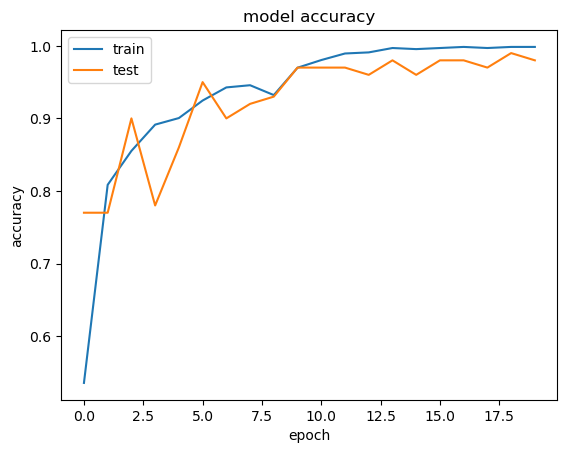

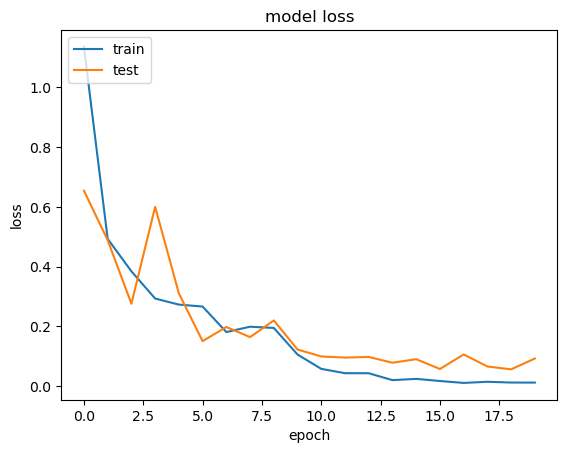

In [53]:
plot_loss_accuracy(history)